**PROJECT : ML-IDS 🔍**

Intelligent IoT Intrusion Detection System This project builds a Machine Learning-based IDS to protect smart homes. With IoT growth, vulnerabilities have increased. Using network traffic data, we apply EDA, feature engineering, and models like Decision Trees to detect threats in real time.

**Import all the libraries we will need for this project 📠**

In [75]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, RocCurveDisplay




**Load the dataset ⬇️**

In [31]:
# Load dataset
df = pd.read_csv("D:\Documents\ESILV\Matières A4\Core Computer Science\Machine Learning\Projet_ML-IDS\Dataset\dataset_invade.csv")

**Analyse the data to understand it and clean it ⬇️**

In [36]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Basic statistics
print("Data statistics:\n", df.describe())

# types
print(df.dtypes)

Missing values:
 duration                  0
protocol_type             0
service                   0
flag                      0
src_bytes                 0
dst_bytes                 0
land                      0
wrong_fragment            0
urgent                    0
hot                       0
logged_in                 0
num_compromised           0
count                     0
srv_count                 0
serror_rate               0
rerror_rate               0
same_srv_rate             0
diff_srv_rate             0
srv_diff_host_rate        0
dst_host_count            0
dst_host_srv_count        0
dst_host_same_srv_rate    0
dst_host_diff_srv_rate    0
attack                    0
dtype: int64
Data statistics:
             duration  protocol_type        service           flag  \
count  148517.000000  148517.000000  148517.000000  148517.000000   
mean      276.779305       1.055751      31.727048       6.963930   
std      2460.683131       0.422304      16.291494       2.774951   
min 

⬆️ 
No Missing Values: There are no missing values in the dataset, meaning no data imputation is required, allowing for a straightforward training process.

Duration, src_bytes, and dst_bytes: These continuous features show high variability, especially in src_bytes and dst_bytes, with values ranging from zero to over a billion. This high variance might require scaling or normalization to improve model performance.

Binary and Discrete Features: Some features, like land, urgent, and logged_in, have low values and can act as flags for certain types of behavior. Additionally, features like wrong_fragment and hot vary minimally but may be critical indicators for certain attacks.

Network Traffic Attributes: Features such as count, srv_count, serror_rate, and rerror_rate are statistical measures of network interactions, which help identify unusual patterns or outliers in traffic. High standard deviations in count and srv_count suggest occasional spikes, potentially indicating bursts of traffic or repeated connection attempts typical in certain attack types.

Service-Related Ratios: Metrics like same_srv_rate, diff_srv_rate, and srv_diff_host_rate provide insight into how connections are distributed across services and hosts. For example, a high same_srv_rate might indicate a consistent connection to one service, while a high srv_diff_host_rate could suggest an attack attempting connections across multiple hosts.

Host-Specific Features: Attributes like dst_host_count and dst_host_srv_count provide details on the concentration of connections to specific hosts. The high variance in these features, especially dst_host_same_srv_rate, may signal unusual access patterns or targeted attacks.

Attack Labels: The attack label is critical for supervised learning approaches, as it allows for training a model to differentiate between normal and potentially malicious activities.

**Data imbalance ⬇️**

In [5]:
# Data imbalance
print("Class distribution:\n", df['attack'].value_counts())

Class distribution:
 attack
No     77054
Yes    71463
Name: count, dtype: int64


⬆️ We can see that we have the same number of attacks and non-attacks (~<10%) so we do not have to use methods to adjust this.

**Encode the Data ⬇️**

In [34]:
# List of categorical columns to encode
categorical_columns = ['protocol_type', 'service', 'flag', 'attack']

# Apply Label Encoding to each categorical column
label_encoders = {}
for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le  # Store the encoder if you need to inverse transform later

⬆️ The colomns 'protocol_type', 'service', 'flag', 'attack' are not numericals, so we have to convert into numericals to use them, for instance, in a correlation matrix.

**Analyse correlation⬇️**

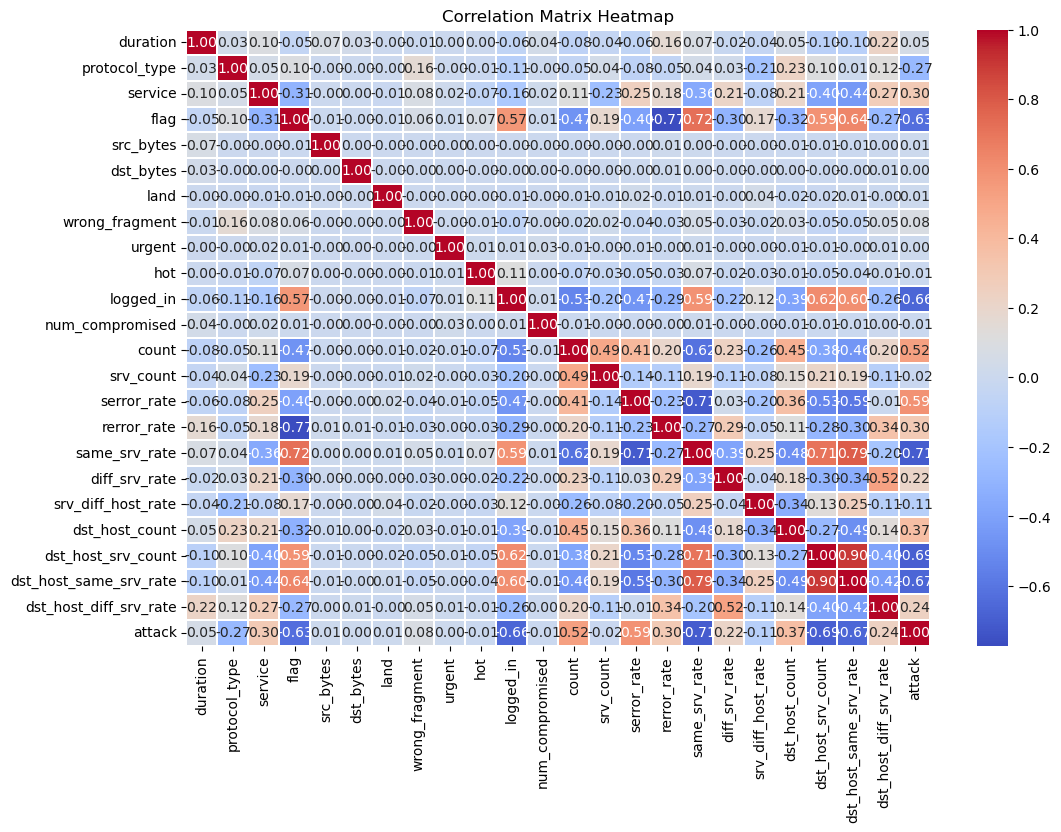

In [ ]:
# Calculate the correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

**Eliminate overlapping data:Z-score⬇️**

In [35]:
# Use of Z-score
z_scores = np.abs(zscore(df))
threshold = 5
data_zscore = df[(z_scores < threshold).all(axis=1)]

# Compare Data
print(f"Original data size: {df.shape[0]}")
print(f"Data size after Z-score filtering: {data_zscore.shape[0]}")

Original data size: 148517
Data size after Z-score filtering: 143396


⬆️I put threshold = 5 because some attacks can generate big values and we don't want to lose them.

As we can see in the data statiscics from the beginning, the features do not have the same scales. 

**So we have to normalize.⬇️** 

In [ ]:
# Idendity colomns
encoded_columns = ['protocol_type', 'service', 'flag', 'attack']
numeric_columns = [col for col in data_zscore.columns if col not in encoded_columns]

scaler = StandardScaler()
data_normalized = data_zscore.copy()

# Normalize only numericlas values
data_normalized[numeric_columns] = scaler.fit_transform(data_zscore[numeric_columns])

print(data_normalized.describe())

           duration  protocol_type        service           flag  \
count  1.433960e+05  143396.000000  143396.000000  143396.000000   
mean  -1.585635e-18       1.060169      31.741478       6.921121   
std    1.000003e+00       0.401546      16.279999       2.792408   
min   -1.207196e-01       0.000000       0.000000       0.000000   
25%   -1.207196e-01       1.000000      20.000000       5.000000   
50%   -1.207196e-01       1.000000      24.000000       9.000000   
75%   -1.207196e-01       1.000000      49.000000       9.000000   
max    1.545020e+01       2.000000      69.000000      10.000000   

          src_bytes     dst_bytes      land  wrong_fragment    urgent  \
count  1.433960e+05  1.433960e+05  143396.0    1.433960e+05  143396.0   
mean  -1.211524e-17  5.946130e-19       0.0   -8.027276e-18       0.0   
std    1.000003e+00  1.000003e+00       0.0    1.000003e+00       0.0   
min   -4.640327e-02 -4.193560e-02       0.0   -4.270191e-02       0.0   
25%   -4.640327e-02 -4

⬆️We can see now that the numerics values (note the ones that have been encoded) have been normalized and have a mean on the same scale.
I compared the correlation matrix of the initial dataset and the normalized dataset. We have almost the same results. This is a good sign, because it means that we haven't altered the direction of the variables, but now the features will have equivalent weight for the prediction model. 

**We split the data for the ML models⬇️**

In [ ]:
# Split Data, features and target
X = data_normalized.drop(columns=['attack']) 
y = data_normalized['attack']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the sizes
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 114716
Test set size: 28680


**Fonction to evaluate the models :⬇️**

In [76]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    result = f"Results for {model} are : accuracy = {accuracy} | precision : {precision} | recall : {recall} | f1 : {f1}"

    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    
    return accuracy, precision, recall, f1, result



**Fonction to create the ROC curve⬇️**

In [64]:
def plot_roc_curve(model, X_test, y_test, title=""):
    y_pred_proba = model.predict_proba(X_test)[:, 1] 
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {title}')
    plt.legend(loc="lower right")
    plt.show()

**Implementation of the PCA⬇️**

In [65]:
pca = PCA(n_components=0.95)

**TEST FONCTIONS🎰**

_Linear regression_

Logistic Regression without PCA:


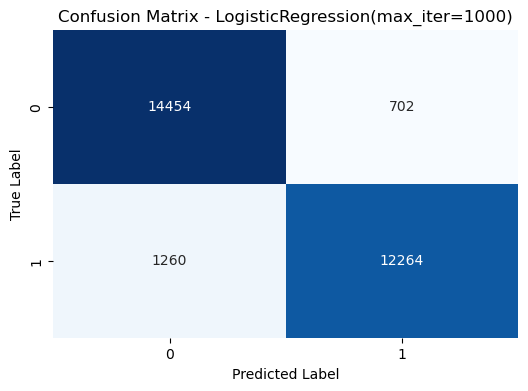

Results for LogisticRegression(max_iter=1000) are : accuracy = 0.9315899581589958 | precision : 0.9320966267301786 | recall : 0.9315899581589958 | f1 : 0.9314877278715209


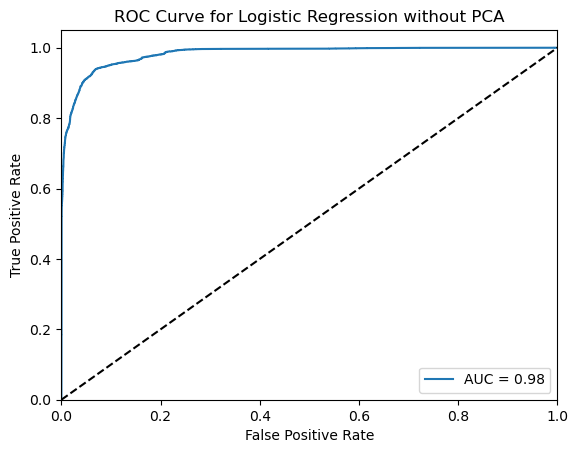

In [77]:
# 1.A Logistic Regression
print("Logistic Regression without PCA:")
log_reg = LogisticRegression(max_iter=1000)
print(evaluate_model(log_reg, X_train, X_test, y_train, y_test)[4])
plot_roc_curve(log_reg, X_test, y_test, title="Logistic Regression without PCA")


Logistic Regression with PCA:


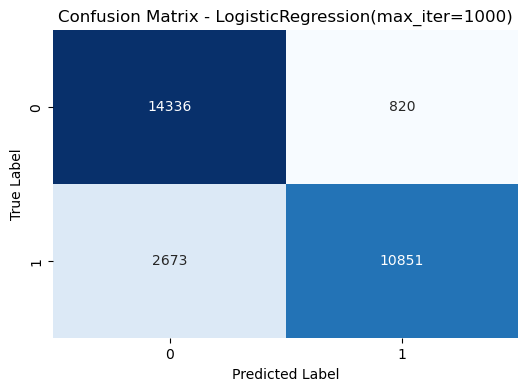

Results for LogisticRegression(max_iter=1000) are : accuracy = 0.878207810320781 | precision : 0.8838218884904563 | recall : 0.878207810320781 | f1 : 0.8772373009748514


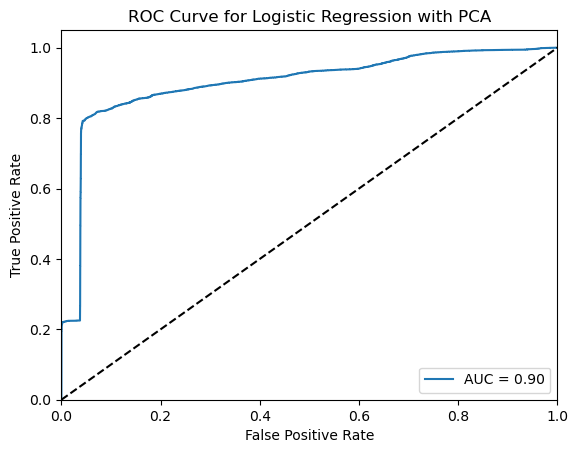

In [78]:
# 1.B Logistic Regression with PCA
print("Logistic Regression with PCA:")
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(evaluate_model(log_reg, X_train_pca, X_test_pca, y_train, y_test)[4])
plot_roc_curve(log_reg, X_test_pca, y_test, title="Logistic Regression with PCA")

_Random Forest_

Random Forest without PCA:


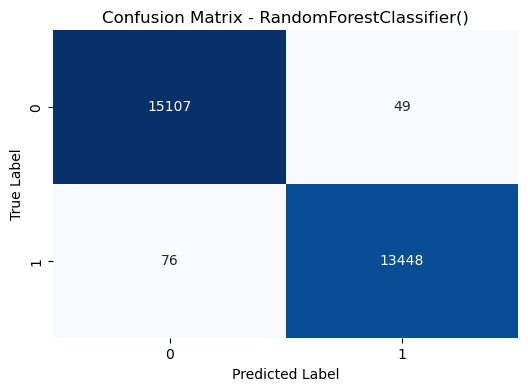

Results for RandomForestClassifier() are : accuracy = 0.9956415620641562 | precision : 0.9956428566727086 | recall : 0.9956415620641562 | f1 : 0.9956413239208731


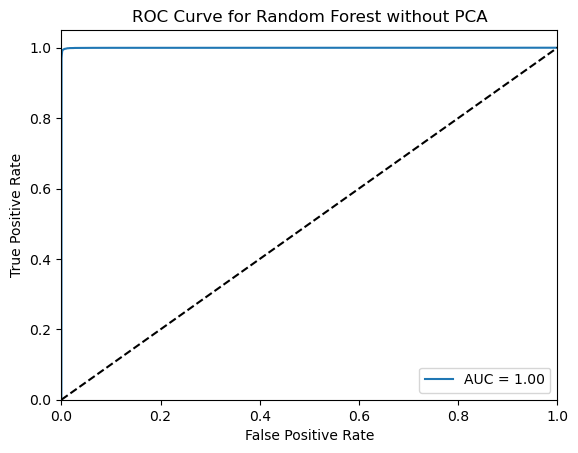

In [79]:
# Random Forest with and without PCA
print("Random Forest without PCA:")
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
print(evaluate_model(rf, X_train, X_test, y_train, y_test)[4])
plot_roc_curve(rf, X_test, y_test, title="Random Forest without PCA")

creation of the models